In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [3]:
df=pd.read_csv("stocks/aaaaa.us.csv")
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1993-02-17,6.3232,7.0566,6.1944,7.0566,3792363,0
1,1993-02-18,7.3143,7.5522,6.6900,6.7494,750785,0
2,1993-02-19,6.6900,6.9377,6.4421,6.6900,376654,0
3,1993-02-22,6.5611,6.5611,6.0656,6.0656,467360,0
4,1993-02-23,6.0656,6.3232,6.0656,6.1944,285945,0


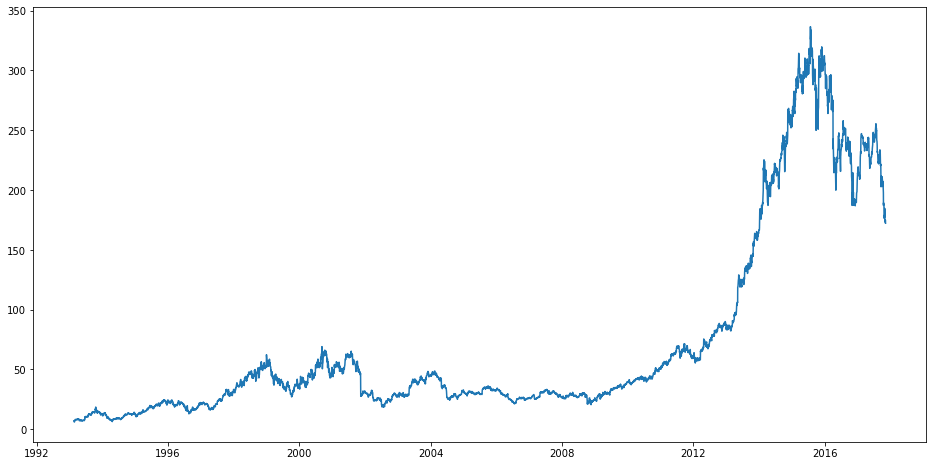

In [4]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [5]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [7]:
print(train_data.shape)
print(valid_data.shape)

(987, 1)
(5241, 1)


In [8]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

Epoch 1/1
 - 49s - loss: 3.0800e-05


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

In [10]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [11]:
lstm_model.save("saved_model.h5")

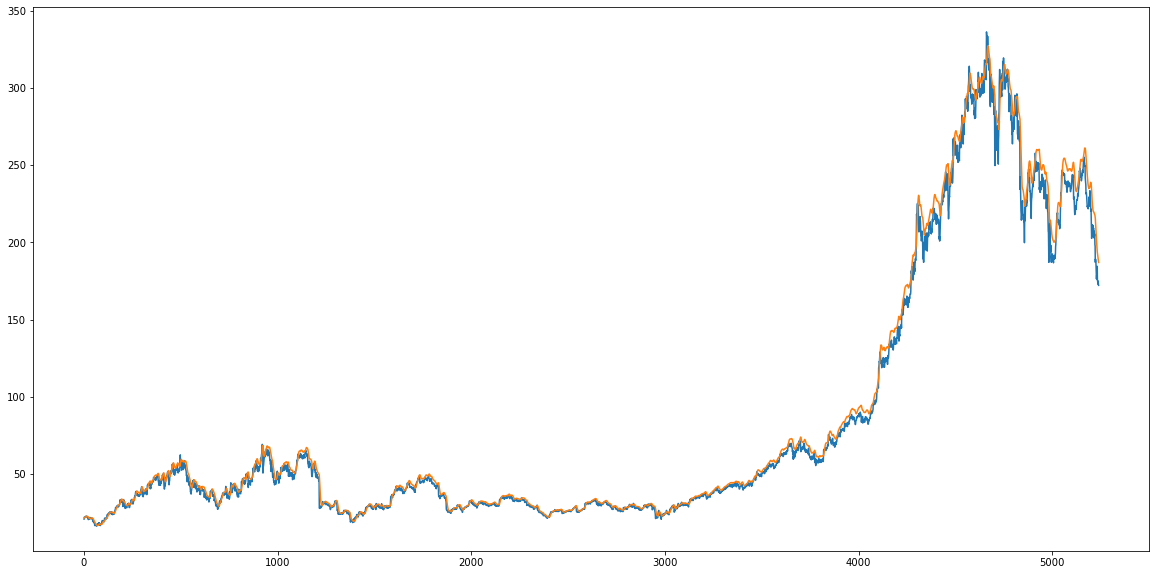

In [12]:
plt.plot(valid_data[:11086,0])
plt.plot(predicted_closing_price[:11086,0])

In [13]:
sum = 0;
for i in range(5240):
    index1 = (predicted_closing_price[i,0])-(valid_data[i,0])
    index2 = abs(index1)
    sum += index2
ave = sum/5241
print('Average difference: ', ave)

Average difference:  3.643129373056559


C:\Users\Hanna Mae Limpag\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


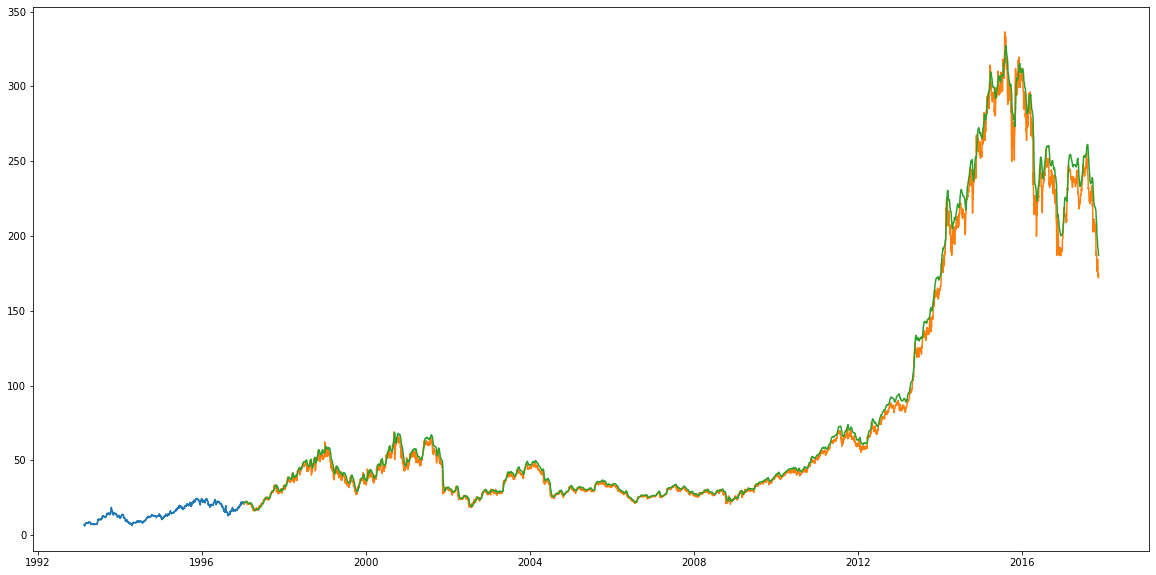

In [14]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])